In [1]:
import itertools
# 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_ta as ta
import yfinance as yf
# 
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

In [2]:
# parameters
num_class = 5
split_date = '2023-04-01'
random_state=42
start_date = '2007-01-01'
end_date = '2024-05-01'

In [3]:
# daily data download
df = yf.download('EURUSD=X', start=start_date, end=end_date)
df.drop(columns=['Volume','Adj Close'], inplace=True)
df.sort_values(by=['Date'],inplace=True)
df.reset_index(inplace=True)
df

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close
0,2007-01-01,1.319801,1.321999,1.317593,1.321895
1,2007-01-02,1.321895,1.329398,1.321755,1.327598
2,2007-01-03,1.327598,1.329098,1.315547,1.317107
3,2007-01-04,1.317107,1.318096,1.308096,1.309295
4,2007-01-05,1.309003,1.310393,1.298398,1.298499
...,...,...,...,...,...
4490,2024-04-24,1.070435,1.071582,1.067920,1.070435
4491,2024-04-25,1.069988,1.073192,1.067874,1.069988
4492,2024-04-26,1.072961,1.075292,1.067555,1.072961
4493,2024-04-29,1.070687,1.073537,1.069096,1.070687


In [4]:
# Feature Engineering (on Returns, not on Price)
# returns for Features (no look-ahead bias):
df['Rp'] = df['Close'].pct_change()
# 
ema_14_rp = df.ta.ema(length=14, close='Rp')
rsi_14_rp = df.ta.rsi(length=14, close='Rp')
emsd_rp = df['Rp'] - ema_14_rp
# Assign the resulting columns to the DataFrame with desired names
df['Rp_ema_14'] = ema_14_rp
df['Rp_rsi_14'] = rsi_14_rp
df['EMSD_Rp'] = emsd_rp
# target
df['Rp'] = df['Close'].pct_change().shift(-1)
# 
df

,Date,Open,High,Low,Close,Rp,Rp_ema_14,Rp_rsi_14,EMSD_Rp
0,2007-01-01,1.319801,1.321999,1.317593,1.321895,0.004315,NaN,NaN,NaN
1,2007-01-02,1.321895,1.329398,1.321755,1.327598,-0.007903,NaN,NaN,NaN
2,2007-01-03,1.327598,1.329098,1.315547,1.317107,-0.005931,NaN,NaN,NaN
3,2007-01-04,1.317107,1.318096,1.308096,1.309295,-0.008246,NaN,NaN,NaN
4,2007-01-05,1.309003,1.310393,1.298398,1.298499,0.004238,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
4490,2024-04-24,1.070435,1.071582,1.067920,1.070435,-0.000417,-0.000026,54.300397,0.004747
4491,2024-04-25,1.069988,1.073192,1.067874,1.069988,0.002779,-0.000078,49.920659,-0.000339
4492,2024-04-26,1.072961,1.075292,1.067555,1.072961,-0.002120,0.000303,52.488117,0.002476
4493,2024-04-29,1.070687,1.073537,1.069096,1.070687,0.000825,-0.000020,48.392906,-0.002100


In [5]:
# training quantiles training
features = ['Rp_ema_14','Rp_rsi_14','EMSD_Rp']
target = 'Rp'
df.dropna(inplace=True)
train_df = df.loc[df.Date < split_date]
test_df = df.loc[df.Date >= split_date]
X_train = train_df[features].values
y_train = train_df[target].values
X_test = test_df[features].values
y_test = test_df[target].values
# scaling
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_quantiles = pd.qcut(y_train, q=num_class, labels=False)

In [6]:
# class prediction
xgb_classifier = XGBClassifier(objective='multi:softmax', num_class=num_class, random_state=random_state)
xgb_classifier.fit(X_train_scaled, y_train_quantiles)
# Predict classes for the test sample
y_train_test = xgb_classifier.predict(X_train_scaled)
y_pred_test = xgb_classifier.predict(X_test_scaled)
y_pred_all = np.concatenate((y_train_test, y_pred_test))
df['Predicted_Class'] = y_pred_all
df

,Date,Open,High,Low,Close,Rp,Rp_ema_14,Rp_rsi_14,EMSD_Rp,Predicted_Class
15,2007-01-22,1.296294,1.297808,1.292892,1.295001,0.005639,-0.001255,45.867823,-0.000209,4
16,2007-01-23,1.295001,1.304393,1.293594,1.302304,-0.004615,-0.000335,57.062827,0.005974,0
17,2007-01-24,1.302406,1.303798,1.295203,1.296294,-0.001773,-0.000906,43.178956,-0.003709,1
18,2007-01-25,1.296496,1.300001,1.291906,1.293996,-0.000853,-0.001022,47.026252,-0.000751,2
19,2007-01-26,1.293594,1.294197,1.288793,1.292892,0.002631,-0.000999,48.247121,0.000146,3
...,...,...,...,...,...,...,...,...,...,...
4489,2024-04-23,1.065405,1.070996,1.063932,1.065405,0.004721,-0.000757,50.267034,0.000362,4
4490,2024-04-24,1.070435,1.071582,1.067920,1.070435,-0.000417,-0.000026,54.300397,0.004747,3
4491,2024-04-25,1.069988,1.073192,1.067874,1.069988,0.002779,-0.000078,49.920659,-0.000339,1
4492,2024-04-26,1.072961,1.075292,1.067555,1.072961,-0.002120,0.000303,52.488117,0.002476,3


In [7]:
# returns profile
conditions = [df['Predicted_Class'].isin([0,1,2,3,4]) # long
              , df['Predicted_Class'].isin([0,1,2,3,4]) # short
              ]
signals = [1
           , -1]
# Create the "signal" column using np.select
df['signal'] = np.select(conditions, signals, default=0)
df['returns'] = df['signal']*df['Rp']
# Returns IS
df['cum_returns'] = (df['returns'] + 1).cumprod()
# sharpe ratios
std_dev = df['returns'].std()*np.sqrt(252)
ar = df['returns'].cumsum().iloc[-1]/((len(df)+1)/365.2)
sharpe_ratio = ar / std_dev
print("sharpe_ratio IS:",sharpe_ratio)
# Returns OOS
test_df = df.loc[df.Date >= split_date].copy()
test_df['cum_returns'] = (test_df['returns'] + 1).cumprod()
# sharpe ratios
std_dev = test_df['returns'].std()*np.sqrt(252)
ar = test_df['returns'].cumsum().iloc[-1]/((len(test_df)+1)/365.2)
sharpe_ratio = ar / std_dev
print("sharpe_ratio OOS:",sharpe_ratio)

sharpe_ratio IS: -0.047562121647009035
sharpe_ratio OOS: -0.11725027626042728


In [8]:
all_classes = list(range(num_class))
# Initialize a DataFrame to store the Sharpe ratios for each combination
sharpe_ratios_df = []
# Generate all possible combinations of long and short classes
for subset_length in range(num_class + 1):
    for long_classes in itertools.combinations(all_classes, r=subset_length):
        print(long_classes)
        short_classes = [item for item in all_classes if item not in long_classes]
        # Filter data based on the long and short classes
        long_condition = df['Predicted_Class'].isin(long_classes)
        short_condition = df['Predicted_Class'].isin(short_classes)
        df['signal'] = np.select([long_condition, short_condition], [1, -1], default=0)
        # Calculate returns
        df['returns'] = df['signal'] * df['Rp']
        # Calculate cumulative returns
        df['cum_returns'] = (df['returns'] + 1).cumprod()
        # Calculate Sharpe ratio for in-sample data
        std_dev_is = df['returns'].std() * np.sqrt(252)
        ar_is = df['returns'].cumsum().iloc[-1] / ((len(df) + 1) / 365.2)
        sharpe_ratio_is = ar_is / std_dev_is
        # Filter test data based on split_date
        test_df = df.loc[df.Date >= split_date].copy()
        # Calculate Sharpe ratio for out-of-sample data
        std_dev_oos = test_df['returns'].std() * np.sqrt(252)
        ar_oos = test_df['returns'].cumsum().iloc[-1] / ((len(test_df) + 1) / 365.2)
        sharpe_ratio_oos = ar_oos / std_dev_oos
        # Append the Sharpe ratios to the DataFrame
        sharpe_ratios_df.append({'Long_Classes': long_classes,
                                                    'Short_Classes': short_classes,
                                                    'Sharpe_Ratio_IS': sharpe_ratio_is,
                                                    'Sharpe_Ratio_OOS': sharpe_ratio_oos
                                                    })
sharpe_ratios_df = pd.DataFrame(sharpe_ratios_df)

()
(0,)
(1,)
(2,)
(3,)
(4,)
(0, 1)
(0, 2)
(0, 3)
(0, 4)
(1, 2)
(1, 3)
(1, 4)
(2, 3)
(2, 4)
(3, 4)
(0, 1, 2)
(0, 1, 3)
(0, 1, 4)
(0, 2, 3)
(0, 2, 4)
(0, 3, 4)
(1, 2, 3)
(1, 2, 4)
(1, 3, 4)
(2, 3, 4)
(0, 1, 2, 3)
(0, 1, 2, 4)
(0, 1, 3, 4)
(0, 2, 3, 4)
(1, 2, 3, 4)
(0, 1, 2, 3, 4)


In [9]:
sharpe_ratios_df.sort_values(by=['Sharpe_Ratio_IS'], ascending=[False],inplace=True)
sharpe_ratios_df

,Long_Classes,Short_Classes,Sharpe_Ratio_IS,Sharpe_Ratio_OOS
25,"(2, 3, 4)","[0, 1]",12.459189,0.465991
15,"(3, 4)","[0, 1, 2]",12.456724,-0.167403
30,"(1, 2, 3, 4)",[0],9.159462,-0.599266
24,"(1, 3, 4)","[0, 2]",9.157372,-1.234144
14,"(2, 4)","[0, 1, 3]",9.025567,0.384459
5,"(4,)","[0, 1, 2, 3]",9.023490,-0.248903
23,"(1, 2, 4)","[0, 3]",6.166667,-0.680852
12,"(1, 4)","[0, 2, 3]",6.164807,-1.316014
13,"(2, 3)","[0, 1, 4]",2.619200,0.832582
4,"(3,)","[0, 1, 2, 4]",2.617492,0.198747


In [10]:
sharpe_ratios_df.sort_values(by=['Sharpe_Ratio_OOS'], ascending=[False],inplace=True)
sharpe_ratios_df

,Long_Classes,Short_Classes,Sharpe_Ratio_IS,Sharpe_Ratio_OOS
19,"(0, 2, 3)","[1, 4]",-6.164807,1.316014
7,"(0, 2)","[1, 3, 4]",-9.157372,1.234144
29,"(0, 2, 3, 4)",[1],2.411035,0.948520
20,"(0, 2, 4)","[1, 3]",-0.155249,0.866837
13,"(2, 3)","[0, 1, 4]",2.619200,0.832582
3,"(2,)","[0, 1, 3, 4]",0.049238,0.750945
8,"(0, 3)","[1, 2, 4]",-6.166667,0.680852
1,"(0,)","[1, 2, 3, 4]",-9.159462,0.599266
25,"(2, 3, 4)","[0, 1]",12.459189,0.465991
14,"(2, 4)","[0, 1, 3]",9.025567,0.384459


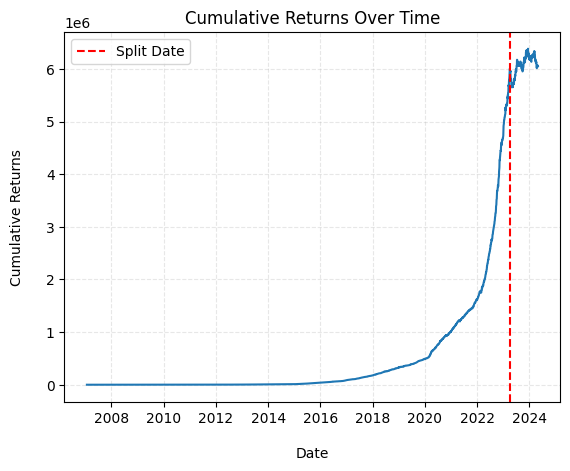

In [11]:
long_classes = [2,3,4]
short_classes = [item for item in all_classes if item not in long_classes]
# Filter data based on the long and short classes
long_condition = df['Predicted_Class'].isin(long_classes)
short_condition = df['Predicted_Class'].isin(short_classes)
df['signal'] = np.select([long_condition, short_condition], [1, -1], default=0)
# Calculate returns
df['returns'] = df['signal'] * df['Rp']
# Calculate cumulative returns
df['cum_returns'] = (df['returns'] + 1).cumprod()

# Plot the cumulative results
plt.plot(df['Date'],df['cum_returns'])
plt.xlabel('\nDate')
# plt.xticks(df['Date'], rotation=90)
plt.ylabel('Cumulative Returns\n')
plt.title('Cumulative Returns Over Time')
plt.grid(True,alpha=0.3,linestyle='--')
split_date = pd.to_datetime(split_date)
plt.axvline(x=split_date, color='r', linestyle='--', label='Split Date')
plt.legend()
plt.show()